In [1]:
import os, sys
os.environ['CUDA_VISIBLE_DEVICES'] = '2,3'
from pathlib import Path
import json
from tqdm import tqdm
import numpy as np
from PIL import Image
import lovely_tensors as lt
lt.monkey_patch()
import torch

from hmr4d.dataset.pure_motion.amass import AmassDataset
from hmr4d.dataset.pure_motion.utils import rotate_around_axis
from hmr4d.dataset.pure_motion.cam_traj_utils_v2 import CameraAugmenterV20, create_rotation_track, create_translation_track
from hmr4d.utils.body_model import BodyModelSMPLX
from hmr4d.utils.geo.hmr_cam import create_camera_sensor
from hmr4d.utils.geo.hmr_global import get_c_rootparam
from hmr4d.utils.geo_transform import transform_mat
from hmr4d.utils.geo.transforms import axis_rotate_to_matrix
from hmr4d.utils.vis.renderer import Renderer, Renderer_Point
from hmr4d.utils.video_io_utils import get_writer
from hmr4d.utils.image_gen.stable_diffusion import ImageGenerator
import third_party.depth_pro.depth_pro as depth_pro
from third_party.depth_pro.utils import get_boundaries_mask, get_depth_image, get_points_3d

device = 'cuda:0'

/home/guangyu/anaconda3/envs/hmr/lib/python3.10/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)
/home/guangyu/anaconda3/envs/hmr/lib/python3.10/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(
/home/guangyu/anaconda3/envs/hmr/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  wa

In [2]:
dataset = AmassDataset(cam_augmentation='v20', motion_frames=120)

smplx = BodyModelSMPLX(
    model_path="inputs/checkpoints/body_models", model_type="smplx",
    gender="neutral", num_pca_comps=12, flat_hand_mean=False,
).to(device)
smplx_colors = torch.tensor(torch.load("hmr4d/utils/body_model/smplx_color.pt")/ 255.)[None]

/home/guangyu/patrick/GVHMR/hmr4d/utils/body_model/smplx_lite.py:243: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  smplx2smpl = torch.load(PROJ_ROOT / "hmr4d/utils/body_mod

In [7]:
width, height = 768, 480
index = 440
seed = 189
np.random.seed(seed)

_, _, K = create_camera_sensor(width, height, 24)

data = dataset._load_data(index)
nframe = data['length']
global_orient_w, transl_w = rotate_around_axis(data["global_orient"], data["transl"], axis="y")
smpl_params_w = {
    'body_pose' : data["body_pose"], 'betas': data["betas"], 
    'global_orient': global_orient_w, 'transl': transl_w
}
w_j3d = smplx(**{k:v.to(device) for k,v in smpl_params_w.items()}).joints.cpu()

def quick_render(T_w2c, smpl_params_w, K):
    offset = smplx.get_skeleton(smpl_params_w["betas"][0].to(device))[0]  # (3)
    global_orient_c, transl_c = get_c_rootparam(smpl_params_w['global_orient'], smpl_params_w['transl'], T_w2c, offset.cpu())
    smpl_params_c = {
        "body_pose": smpl_params_w["body_pose"],  # (F, 63)
        "betas": smpl_params_w["betas"],  # (F, 10)
        "global_orient": global_orient_c,  # (F, 3)
        "transl": transl_c,  # (F, 3)
    }
    verts = smplx(**{k:v.to(device) for k,v in smpl_params_c.items()}).vertices
    joints = smplx(**{k:v.to(device) for k,v in smpl_params_c.items()}).joints

    renderer_c = Renderer(int(K[0,2].item() * 2), int(K[1,2].item() * 2),
                          device="cuda", faces=smplx.faces, K=K)
    pred_c_joints, pred_c_valids = renderer_c.project_points_to_full_image(joints[0])
    canvas = renderer_c.render_openpose(pred_c_joints, pred_c_valids)
    smpl_rgbs, smpl_depths = renderer_c.render_mesh(
        verts[0], colors=smplx_colors, return_depth=True
    )
    total_img = Image.fromarray(np.concatenate([smpl_rgbs, canvas], axis=1))
    return total_img
    

In [4]:
# 1. Nose : 55, 2. Neck : 12, 
# 3. Right Shoulder : 17, 4. Right Elbow : 19, 5. Right Wrist : 21
# 6. Left Shoulder : 16,  7. Left Elbow : 18,  8. Left Wrist : 20
# 9. Right Hip : 2,      10. Right Knee : 5,  11. Right Ankle : 8
# 12. Left Hip : 1,  13. Left Knee : 4,  14. Left Ankle : 7
# 15. Right Eye : 56, 16. Left Eye : 57, 17. Right Ear : 58, 18. Left Ear : 59 

def project(joints, R, t, K):
    joints_c = torch.einsum("ij,bkj->bki", R, joints) + t[None, None, :]
    z = joints_c[..., 2].clamp(min=1e-6)
    u = K[0, 0] * (joints_c[..., 0] / z) + K[0, 2]
    v = K[1, 1] * (joints_c[..., 1] / z) + K[1, 2]
    uv = torch.cat([u, v]).transpose(1,0)
    area = (uv.max(0).values[0] - uv.min(0).values[0]) * (uv.max(0).values[1] - uv.min(0).values[1])
    return uv, area

def human_look_direction_cam(
    joints_w,         # (J, 3) or (B, J, 3) in world coords
    R_w2c,            # (3, 3) world -> camera
):
    # Default indices for your 127-joint layout
    if joints_w.dim() == 2:
        joints_w = joints_w.unsqueeze(0)  # (1, J, 3)

    neck, jaw, re, le, nose = 12, 22, 56, 57, 55
    # Head direction in world space: from neck to face center
    face = (joints_w[:, nose] + joints_w[:, re] + joints_w[:, le] + joints_w[:, jaw]) / 4.0
    head_dir_w = face - joints_w[:, neck]
    head_dir_w = head_dir_w / (head_dir_w.norm(dim=-1, keepdim=True) + 1e-6)
    # Convert to camera space
    head_dir_c = torch.einsum("ij,bj->bi", R_w2c, head_dir_w)
    head_dir_c = head_dir_c / (head_dir_c.norm(dim=-1, keepdim=True) + 1e-6)
    return head_dir_c

def get_yaw_range(joints_w, pitch, roll):
    head_dir_w = human_look_direction_cam(joints_w, R_w2c=torch.eye(3))[0]

    R_y_upsidedown = torch.tensor([[-1, 0, 0], [0, -1, 0], [0, 0, 1]]).float()
    pitch_rm = axis_rotate_to_matrix(pitch, axis="x", use_deg=True)[0]
    roll_rm = axis_rotate_to_matrix(roll, axis="z", use_deg=True)[0]
    M = roll_rm @ pitch_rm
    v = R_y_upsidedown @ head_dir_w
    a = M[2, :]

    vx, vy, vz = v.tolist()
    ax, ay, az = a.tolist()

    A = ax * vx + az * vz
    B = ax * vz - az * vx
    C = ay * vy
    D = -(C + 1e-12)
    R = np.sqrt(A*A + B*B)

    if R < 1e-12:
        if C < -1e-12:
            return [(0.0, 360.0)]
        else:
            return []

    alpha = np.arctan2(A, B)
    t = D / R  # threshold for sin(theta)

    # Strict inequality handling
    if t <= -1.0:
        return []
    if t >= 1.0:
        return [(0.0, 360.0)]

    theta_a = np.arcsin(t)        # in (-pi/2, pi/2)
    theta_b = np.pi - theta_a   # in (pi/2, 3pi/2)

    # sin(theta) < t holds on (theta_b, 2pi + theta_a)
    start_deg = (theta_b - alpha) * 180.0 / np.pi
    end_deg   = (theta_a - alpha) * 180.0 / np.pi

    s = start_deg % 360.0 if start_deg >= 0.0 else (360.0 + start_deg % 360.0)
    e = end_deg % 360.0 if end_deg >= 0.0 else (360.0 + end_deg % 360.0)
    if abs(s - e) < 1e-12:
        return []  # ambiguous; handled upstream
    elif s < e:
        return [(s, e)]
    else:
        return [(s, 360.0 + e)]


yaw: -75.00, pitch: 0.00, roll: 0.00
tx: 0.00, ty: 0.00, tz: 4.00
tensor[1, 3] x∈[-0.719, 0.022] μ=-0.464 σ=0.421 [[0.022, -0.719, -0.694]]


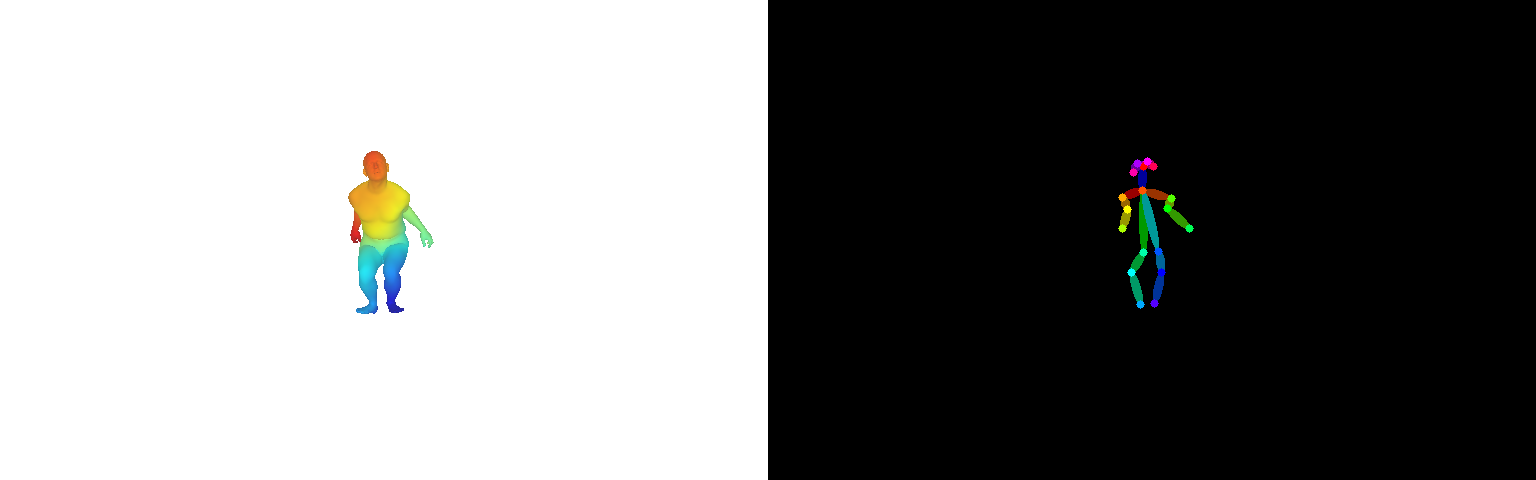

In [8]:
# R0_w2c, t0_w2c = create_camera(w_j3d[0,0], width, K_fullimg[0,0])
w_root = w_j3d[0,0]
focal = K[0,0]

yaw, pitch, roll = -75.0, 0.0, 0.0
R_y_upsidedown = torch.tensor([[-1, 0, 0], [0, -1, 0], [0, 0, 1]]).float()
yaw_rm = axis_rotate_to_matrix(yaw, axis="y", use_deg=True)
pitch_rm = axis_rotate_to_matrix(pitch, axis="x", use_deg=True)
roll_rm = axis_rotate_to_matrix(roll, axis="z", use_deg=True)
R_w2c = (roll_rm @ pitch_rm @ yaw_rm @ R_y_upsidedown).squeeze(0)  # (3, 3)
print(f"yaw: {yaw:.2f}, pitch: {pitch:.2f}, roll: {roll:.2f}")

tz = 4.0 #1.5 ~ 4.5
max_dist_in_fov = (width / 2) / focal * tz
tx, ty = 0.0, 0.0
tx *= max_dist_in_fov
ty *= max_dist_in_fov

dist = torch.tensor([tx, ty, tz], dtype=torch.float)
print(f"tx: {tx:.2f}, ty: {ty:.2f}, tz: {tz:.2f}")
t_w2c = dist - torch.matmul(R_w2c, w_root)

T_w2c = transform_mat(R_w2c, t_w2c)
print(human_look_direction_cam(w_j3d[0], R_w2c))

quick_render(T_w2c, smpl_params_w, K)

Percentage : 0.06%
Percentage : 2.93%
Head looking backwards camera: tensor[1] bool [True] (-0.08)
Backward facing detected (z=-0.08), flip camera
Head looking backwards camera: tensor[1] bool [False] (-0.25)
Margin adjusting: (142.80, 672.80, 206.99, 854.73) dx_px=87.6, dy_px=-470.7
Margin adjusting: (244.88, 188.89, 282.46, 327.43) dx_px=0.0, dy_px=51.1
Margin adjusting: (244.88, 241.43, 282.46, 377.69) dx_px=0.0, dy_px=0.0
Camera rotation deltas (yaw, pitch, roll): (-6.7, -0.1, -2.0)
Camera translation deltas (tx, ty, tz): (0.44, -0.07, -0.36)


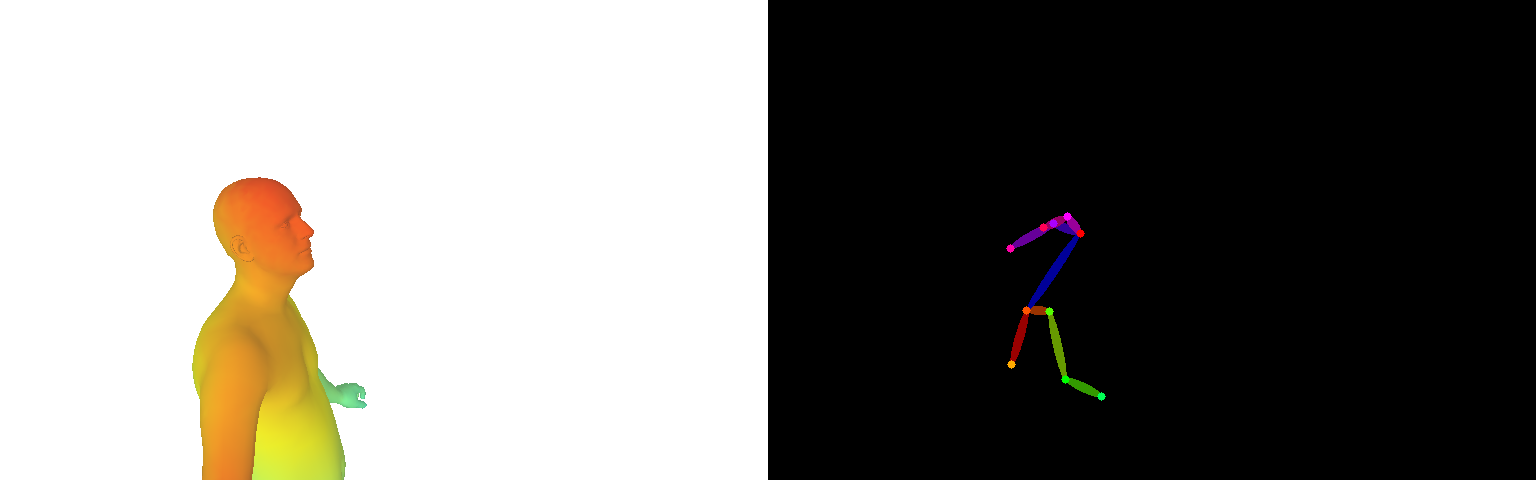

In [14]:
width, height = 768, 480
index = 2367
seed = 514
np.random.seed(seed)

data = dataset._load_data(index)
nframe = data['length']
global_orient_w, transl_w = rotate_around_axis(data["global_orient"], data["transl"], axis="y")
smpl_params_w = {
    'body_pose' : data["body_pose"], 'betas': data["betas"], 
    'global_orient': global_orient_w, 'transl': transl_w
}
w_j3d = smplx(**{k:v.to(device) for k,v in smpl_params_w.items()}).joints.cpu()

cam_augmentor = CameraAugmenterV20(width, height, f_fullframe=24)
T_w2c, R_linspace, t_linspace, meta = cam_augmentor(w_j3d, seed=seed)
K_fullimg = cam_augmentor.K_fullimg

# offset = smplx.get_skeleton(data["betas"][0].to(device))[0]  # (3)
# global_orient_c, transl_c = get_c_rootparam(global_orient_w, transl_w, T_w2c, offset.cpu())
# smpl_params_c = {
#     "body_pose": data["body_pose"],  # (F, 63)
#     "betas": data["betas"],  # (F, 10)
#     "global_orient": global_orient_c,  # (F, 3)
#     "transl": transl_c,  # (F, 3)
# }
quick_render(T_w2c, smpl_params_w, K_fullimg)

# batch = dataset[index]
# nframe = batch["length"]
# K_fullimg = batch['K_fullimg'][0]
# smpl_params_c = batch['smpl_params_c']
# torch.save(batch, output_path / "batch_meta.pt")

# verts = smplx(**{k:v.to(device) for k,v in smpl_params_c.items()}).vertices
# joints = smplx(**{k:v.to(device) for k,v in smpl_params_c.items()}).joints



In [ ]:

writer1 = get_writer(output_path / 'smpl_render.mp4', fps=30, crf=23)
writer2 = get_writer(output_path / 'hand_render.mp4', fps=30, crf=23)
for j in tqdm(range(nframe), desc=f"Rendering Global"):
    black_backg = np.zeros((height, width, 3)).astype(np.uint8)
    smpl_rgbs, smpl_depths = renderer_c.render_mesh(
        verts[j], background=black_backg, 
        colors=smplx_colors, return_depth=True
    )
    hand_rgbs, hand_depths = renderer_c.render_mesh(
        verts[j, hand_idxs], background=black_backg, faces=hand_faces,
        colors=hand_colors,  return_depth=True
    )
    unify_mask = (hand_depths <= smpl_depths+0.01)[..., None]

    refined_hand_rgbs = np.clip(
        hand_rgbs * unify_mask + np.zeros_like(hand_rgbs) * (1 - unify_mask), 
    0, 255).astype(np.uint8)

    writer1.write_frame(smpl_rgbs)
    writer2.write_frame(refined_hand_rgbs)
writer1.close()
writer2.close()

pred_c_joints, pred_c_valids = renderer_c.project_points_to_full_image(joints[0])
canvas = renderer_c.render_openpose(pred_c_joints, pred_c_valids)
Image.fromarray(canvas)

In [ ]:
img_gen = ImageGenerator(device=device)
depth_model, depth_transform = depth_pro.create_model_and_transforms(device=device)
depth_model = depth_model.eval()

In [ ]:
prompt="A young man with short, slightly wavy hair and light stubble, wearing a fitted beige jacket over a white t-shirt and dark denim jeans, stands confidently in an open plaza, captured mid-movement as he leans forward with one arm extended and the other bent close to his torso. His posture suggests a casual yet expressive gesture, as if greeting someone or emphasizing a point in conversation. The scene takes place in a modern city square paved with smooth stone tiles, surrounded by contemporary glass-and-steel office buildings that reflect the warm afternoon sunlight. Behind him, a wide set of shallow steps leads up to a public terrace lined with minimalist metal railings and rectangular planters filled with ornamental grasses. A few pedestrians are scattered in the distance, softly out of focus, contributing to a sense of everyday urban life. The lighting is natural and directional, casting soft shadows on the ground and subtly highlighting the contours of the man’s face and clothing. The overall atmosphere is realistic and cinematic, capturing a spontaneous moment within a clean, modern urban environment."
seed = 42
pose_base = img_gen.step1(
    prompt=prompt,
    image=Image.fromarray(canvas),
    width=width, height=height, 
    generator = torch.Generator(device='cuda').manual_seed(seed)
)
pose_final = img_gen.step2(
    prompt=prompt,
    image=pose_base[0],
    width=width*2, height=height*2,
    generator = torch.Generator(device='cuda').manual_seed(seed)

)
final_img = pose_final[0].resize((width, height))
final_img.save(output_path / "reference.png")
final_img

In [ ]:
prediction = depth_model.infer(depth_transform(np.array(final_img)), f_px=K_fullimg[0,0].to(device))
depth = torch.clip(prediction["depth"], 1e-4, 100)  # Depth in [m].

key_3d_index = (pred_c_joints[0,:,1] * width + pred_c_joints[0,:, 0]).numpy().astype(int)
key_3d_index = key_3d_index[pred_c_valids[0].numpy().astype(bool)]
depth_avg = depth.reshape(-1)[key_3d_index].median().item()

boundary_mask = get_boundaries_mask((1 / (depth + 1e-7))[None, None], sobel_threshold=0.35)[0, 0].reshape(-1).cpu()

color_depth = get_depth_image(depth.detach().cpu().numpy(), min_depth=0.1, max_depth=250.0)
color_depth.save(output_path / "depth.png")
color_depth

In [ ]:
start_elevation = 5.0

points3d = get_points_3d(depth, K_fullimg)
c2w_0 = torch.eye(4)
c2w_0[2, 3] = -depth_avg
R_elevation = axis_rotate_to_matrix(-start_elevation, 'x', with_trans=True, use_deg=True)[0]
c2w_0 = R_elevation @ c2w_0
points3d = (c2w_0.numpy()[:3] @ points3d.T).T
colors = np.array(final_img).reshape(height * width, 3) / 255.

c2ws = c2w_0.clone()
R_tmp = c2ws[:3,:3]
R_tmp[:, 0] = -R_tmp[:, 0]
R_tmp[:, 1] = -R_tmp[:, 1]
T_tmp = c2ws.inverse()[:3, -1]

R_w2c_tmp, _1 = create_rotation_track(R_tmp, nframe, yaw=-meta['yaw'], pitch=-meta['pitch'], roll=-meta['roll'], linspace=R_linspace)
t_w2c_tmp, _2 = create_translation_track(R_tmp, T_tmp, nframe, tx=meta['tx'], ty=meta['ty'], tz=meta['tz'], linspace=t_linspace)
T_w2c_tmp = transform_mat(R_w2c_tmp, t_w2c_tmp)

cam_info = {
    "intrinsic": K_fullimg.numpy().tolist(), 
    "extrinsic": T_w2c_tmp.numpy().tolist(), 
    "height": height, "width": width
}
Path(output_path / "cam_info.json").write_text(json.dumps(cam_info))

In [ ]:
renderer_pc = Renderer_Point(width, height, K_fullimg, device=device)
point_cloud = renderer_pc.create_point_cloud(points3d, colors, boundary_mask=boundary_mask)

writer1 = get_writer(output_path / 'render.mp4', fps=30, crf=23)
writer2 = get_writer(output_path / 'render_mask.mp4', fps=30, crf=23)
writer3 = get_writer(output_path / 'combined_render.mp4', fps=30, crf=23)

for j in tqdm(range(nframe), desc=f"Rendering Global"):
    camera = renderer_pc.create_camera(T_w2c_tmp[j:j+1].to(device))
    render_rgb, render_mask = renderer_pc(point_cloud, camera)
    
    render_smpl_rgbs, render_smpl_masks = renderer_c.render_mesh(
        verts[j], background=np.zeros((height, width, 3)).astype(np.uint8), 
        colors=smplx_colors,
        return_mask=True
    )
    render_fused_smpl_rgbs = np.clip(
        render_smpl_rgbs * render_smpl_masks + render_rgb * (1 - render_smpl_masks), 
    0, 255).astype(np.uint8)

    writer1.write_frame(render_rgb)
    writer2.write_frame(render_mask)
    writer3.write_frame(render_fused_smpl_rgbs)

writer1.close()
writer2.close()
writer3.close()

In [ ]:
# motion_files = torch.load("inputs/AMASS/hmr4d_support/smplxpose_v2.pth")
# seqs = {k: v for k,v in motion_files.items() if 'moyo_smplxn' not in k and v['pose'].shape[0] >= 25}
# print(f"Total motion files: {len(seqs):,}")

# ### AMASS Train Dataset --Load Data-- ###
# key = 'inputs/smplx_amass/smplxn_raw/Transitions/Transitions/mazen_c3d/sit_jumpinplace_stageii.npz'
# start, end = 92, 212
# raw_data = seqs[key]
# raw_len = raw_data["pose"].shape[0]
# nframe = end - start

# data = {
#     "body_pose": raw_data["pose"][start:end, 3:],  # (F, 63)
#     "betas": raw_data["beta"].repeat(end-start, 1),  # (10)
#     "global_orient": raw_data["pose"][start:end, :3],  # (F, 3)
#     "transl": raw_data["trans"][start:end, :3],  # (F, 3)
#     "data_name" : "amass"
# }
# # data = interpolate_smpl_params(data, motion_frames_len)
# data["global_orient"], data["transl"], _ = get_tgtcoord_rootparam(
#     data["global_orient"], data["transl"], tsf="az->ay",
# )
# global_orient_w, transl_w = rotate_around_axis(data["global_orient"], data["transl"], axis="y")
# smpl_params_w = {
#     'body_pose' : data["body_pose"], 'betas': data["betas"], 
#     'global_orient': global_orient_w, 'transl': transl_w
# }
# w_j3d = smplx(**{k:v[0:1].to(device) for k,v in smpl_params_w.items()}).joints.cpu()

# # kp3d = smplx_coco(**{k: v.to(device) for k,v in smpl_params_w.items()})
# # np.save("coco_17joints.npy", kp3d.cpu().float().numpy())
# # smplx_out = smplx(**{k: v.to(device) for k,v in smpl_params_w.items()})
# # np.save("full_vertices.npy", smplx_out.vertices.cpu().float().numpy())
# # np.save("full_joints.npy", smplx_out.joints.cpu().float().numpy())

# width, height, f_fullframe = 768, 480, 24
# width, height, K_fullimg = create_camera_sensor(width, height, f_fullframe)

# np.random.seed(256)
# R0_w2c, t0_w2c = create_camera(w_j3d[0,0], width, K_fullimg[0,0])  # (3, 3) and (3,)
# print(t0_w2c.v)

# R0_new_w2c, t0_new_w2c = adjust_camera_for_rel_area(
#     w_j3d, R0_w2c, t0_w2c, K_fullimg, 
#     0.005, 0.15, l_margin=0.4, t_margin=0.6, r_margin=0.8, b_margin=0.8)
# print(t0_new_w2c.v)

# T0_w2c = transform_mat(R0_new_w2c, t0_new_w2c)

# R_w2c, R_linspace = create_rotation_track(R0_new_w2c, nframe, yaw=5)
# t_w2c, t_linspace = create_translation_track(R0_new_w2c, t0_new_w2c, nframe, tx=0.5)
# T_w2c = transform_mat(R_w2c, t_w2c)
# cam_angvel = compute_cam_angvel(T_w2c[:, :3, :3])  # (F, 6)

# offset = smplx.get_skeleton(data["betas"][0].to(device))[0]  # (3)
# global_orient_c, transl_c = get_c_rootparam(global_orient_w, transl_w, T_w2c, offset.cpu())
# smpl_params_c = {
#     "body_pose": data["body_pose"],  # (F, 63)
#     "betas": data["betas"],  # (F, 10)
#     "global_orient": global_orient_c,  # (F, 3)
#     "transl": transl_c,  # (F, 3)
# }
# verts = smplx(**{k:v.to(device) for k,v in smpl_params_c.items()}).vertices
# joints = smplx(**{k:v.to(device) for k,v in smpl_params_c.items()}).joints